In [4]:
%pylab inline
import scipy
from scipy.sparse import coo_matrix, csr_matrix, csc_matrix, block_diag, identity, hstack
#import matplotlib as mpl
import matplotlib.pyplot as plt
from pyiga import bspline, vform, geometry, vis, solvers, utils, topology, algebra
from pyiga import assemble
#from patchmesh import *
from sksparse.cholmod import cholesky
#from patchmesh3D import *
#from multipatch import *
from pyiga import adaptive as adap
import itertools
import time

np.set_printoptions(linewidth=100000)
np.set_printoptions(precision=5)
np.set_printoptions(formatter={'float_kind':"{:.3f}".format})

Populating the interactive namespace from numpy and matplotlib


/home/wolfman/anaconda3/lib/python3.9/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['identity', 'cholesky', 'hstack']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [5]:
def compute_active_constr(Constr):
    #fast variant
    
    a=(Constr>1e-12).sum(axis=1).A.ravel(); b=(Constr<-1e-12).sum(axis=1).A.ravel()
    activeConstraints=np.where(np.bitwise_or(np.bitwise_and(a>0,b==1),np.bitwise_and(a==1,b>0)))[0]
    #sign = np.where(b==1 & a>0)
    
    #signs=1.*((a<=1) | (a+b==0))-1.*((a>1)&(a+b>0))
    #print(signs)
    #S=scipy.sparse.spdiags(signs,0,len(a),len(a))
    
    #Constr = S@Constr
    
    # assert np.all(((a[activeConstraints]==1) | (b[activeConstraints]==1))), 'error in constraint matrix.'

    #variant 1
    # activeConstraints=[]
    # for r in range(Constr.shape[0]):
    #     a = 0
    #     b = 0
    #     for ind in range(Constr.indptr[r], Constr.indptr[r+1]):
    #         if Constr.data[ind] > 1e-12:
    #             a += 1
    #         if Constr.data[ind] < -1e-12:
    #             b += 1
    #     if (a==1 and b>0) or (b==1 and a>0):
    #         activeConstraints.append(r)
    #         #print("{}: {}, {}".format(r,a,b))
    #         #if not (a==1 or b==1): 
    #             #print(a,b)
    #             #print(Constr[r,:])
    #         #assert (a==1 or b==1), 'error in constraint matrix.'
    #         if b==1 and a>0:
    #             #print( "Re-sign" )
    #             Constr[r,:] *= -1
                
    return np.array(activeConstraints)

In [16]:
kv=bspline.make_knots(1,0.0,1.0,2)

In [17]:
kv

KnotVector(array([0.000, 0.000, 0.500, 1.000, 1.000]), 1)

In [33]:
q=0.5
kv=kv.h_refine(new_knots=[kv.mesh[0]*q + kv.mesh[1]*(1-q),kv.mesh[-1]*q + kv.mesh[-2]*(1-q)])

In [34]:
kv

KnotVector(array([0.000, 0.000, 0.008, 0.016, 0.031, 0.062, 0.125, 0.250, 0.500, 0.750, 0.875, 0.938, 0.969, 0.984, 0.992, 1.000, 1.000]), 1)

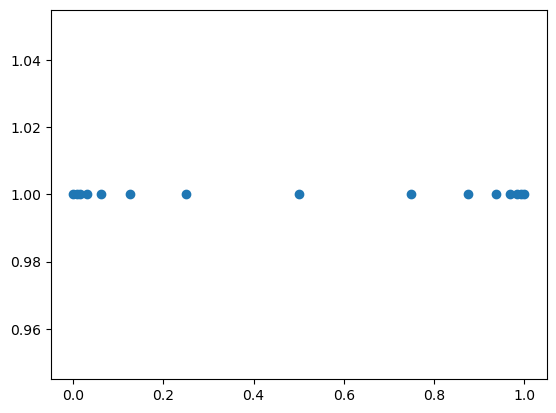

In [35]:
plt.scatter(kv.mesh,1+kv.mesh*0)

In [22]:
deg=3
kvs = [2 * (bspline.make_knots(deg, 0.0, 1.0, 3),)]
geos = [geometry.unit_square()]
patches = [(k, g) for k, g in zip(kvs,geos)]
M = topology.PatchMesh(patches)
MP = assemble.Multipatch(M, automatch=True)
maxiter=10
for i in range(maxiter):
    print(i)
    P = MP.h_refine(h_ref={i:(i+1)%2}, return_P=True)

# MP.h_refine(h_ref={0:0});
# MP.h_refine(h_ref={0:1});
# MP.h_refine(h_ref={4:0});
# MP.h_refine(h_ref={0:0});
# MP.h_refine(h_ref={1:1});
#MP.h_refine(h_ref={7:0});
# MP.h_refine(h_ref={2:1});
# MP.h_refine(h_ref={0:-1,1:0,2:None,3:-1});
#MP.patch_refine(h_ref={3:None});
#u_= MP.L2projection(lambda x,y: x+y+x*y**2)
# MP.mesh.draw(plt.figure())
# axis('scaled');

#MP.plot(u_)
#MP.mesh.draw(knots=True)
#axis('scaled');
#plt.show()
#P=MP.p_refine(p_inc=1, return_P=True)
#u_1= MP.L2projection(lambda x,y: x+y+x*y**2)
# MP.mesh.draw(plt.figure())
# axis('scaled');
#MP.plot(P@u_-u_1)
#MP.mesh.draw(knots=True)

Basis setup took 0.002119779586791992 seconds
0
Refinement took 0.00168609619140625 seconds
Basis setup took 0.005939006805419922 seconds
Prolongation took 0.0048809051513671875 seconds
1
Refinement took 0.0010619163513183594 seconds
Basis setup took 0.004465579986572266 seconds
Prolongation took 0.004918098449707031 seconds
2
Refinement took 0.0010018348693847656 seconds
Basis setup took 0.010262012481689453 seconds
Prolongation took 0.005012989044189453 seconds
3
Refinement took 0.0011036396026611328 seconds
Basis setup took 0.007417440414428711 seconds
Prolongation took 0.004622220993041992 seconds
4
Refinement took 0.001256704330444336 seconds
Basis setup took 0.007256984710693359 seconds
Prolongation took 0.004347085952758789 seconds
5
Refinement took 0.0010383129119873047 seconds
Basis setup took 0.0072994232177734375 seconds
Prolongation took 0.004227161407470703 seconds
6
Refinement took 0.001018524169921875 seconds
Basis setup took 0.007611513137817383 seconds
Prolongation too

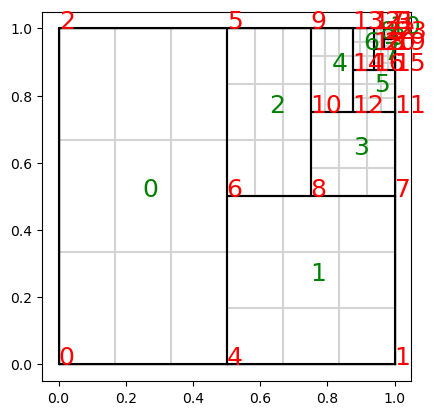

In [23]:
MP.mesh.draw(vertex_idx=True, patch_idx=True, knots=True)

In [8]:
M=topology.PatchMesh(patches=[(2*(bspline.make_knots(2,0.0,1.0,3),),geometry.unit_square())])
MP = assemble.Multipatch(M, automatch=True)

Basis setup took 0.0038220882415771484 seconds


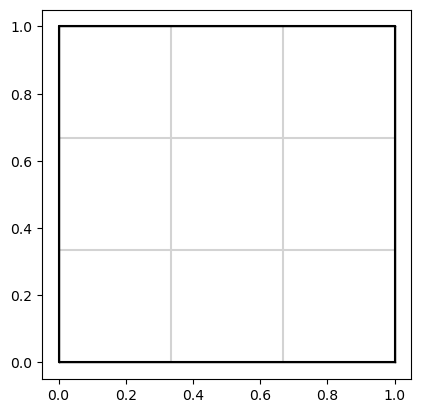

In [7]:
M.draw(knots=True)

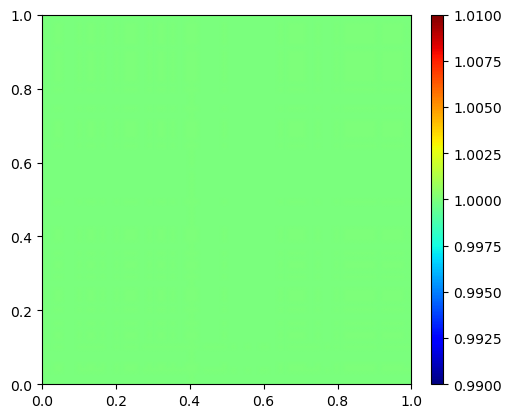

In [10]:
MP.plot(np.ones(MP.numdofs))

In [64]:
X=Y=np.linspace(0,1,10)

In [65]:
C=np.random.rand(81).reshape((9,9))

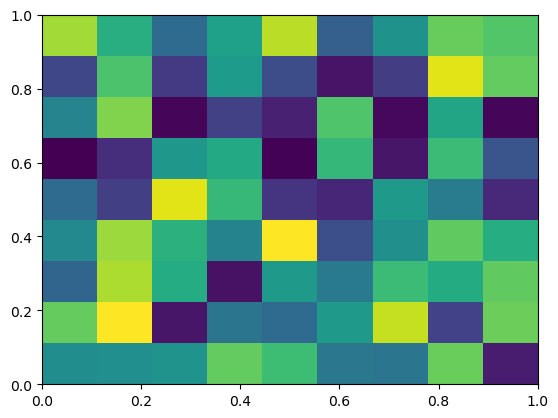

In [66]:
fig,ax=plt.subplots()
ax.pcolormesh(X,Y,C,shading='flat', vmin=C.min(), vmax=C.max())

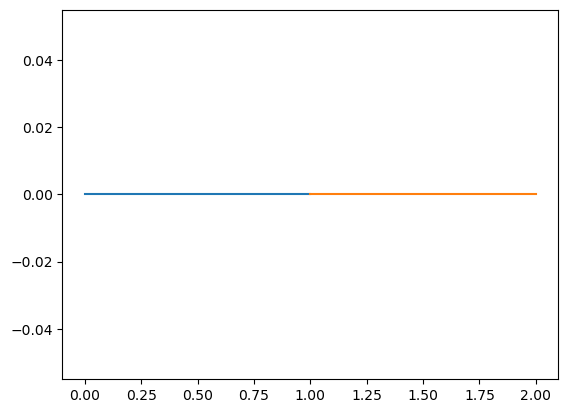

In [73]:
fig,ax=plt.subplots();
ax.plot([0.0,1.0],[0.0,0.0])
ax.plot([1.0,2.0],[0.0,0.0])

In [3]:
P=np.array([[0,1,0,2],
            [0,0,1,2]])

In [11]:
kvy = [8,2,8,5,8,4]
kvx = [2,4,3,6,5,8]

kvs=[(bspline.make_knots(1,0.0,1.0,xN),bspline.make_knots(1,0.0,1.0,yN)) for xN,yN in zip(kvx,kvy)]
geos=[geometry.unit_square(support=((0.,1.),(0.0,0.5))).scale((2,1)),
      geometry.unit_square(support=((0.,1.),(0.5,1.))).scale((2,1)),
      geometry.Quad(np.array([[0.,2.,1.,2.],
                              [1.,1.,2.,2.]])),
      geometry.Quad(np.array([[2.,3.,2.,3.5],
                              [1.,1.,2.,2.5]])),
      geometry.Quad(np.array([[2.,3.,3.,3.5],
                              [1.,0.,1.,0.5]])),
      geometry.Quad(np.array([[2.,2.5,2.,3.],
                              [0.,-0.5,1.,0.]])),]

patches = [(tuple(bspline.mapto(k[d],lambda x: g.support[d][1]*x + g.support[d][0]*(1-x)) for d in range(2)), g) for k, g in zip(kvs,geos)]
M=topology.PatchMesh(patches)
M.sanity_check()
#M.h_refine(patches={5:-1, 2:-1});

((0.0, 1.0), (0.0, 0.5))
((0.0, 1.0), (0.5, 1.0))


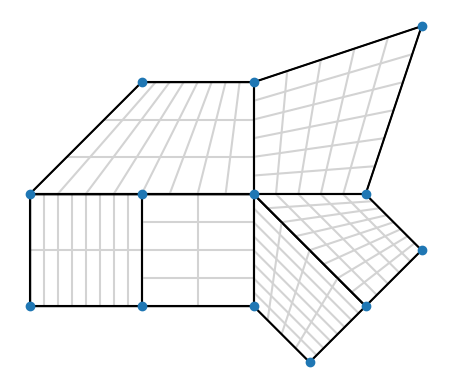

In [7]:
M.draw(knots=True, nodes=True, patch_idx=False,color={0:'white'})
plt.axis('off');

In [12]:
MP=assemble.Multipatch(M,automatch=True)

Basis setup took 0.023770809173583984 seconds


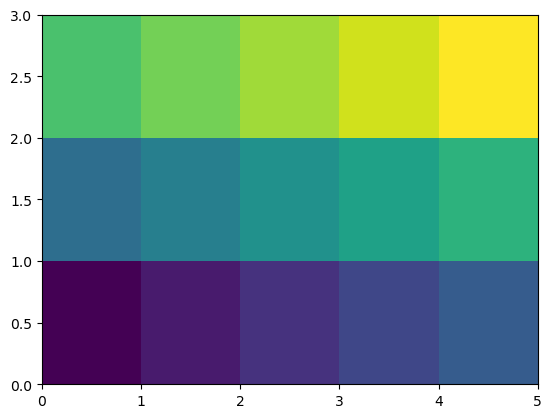

In [43]:
nrows = 3
ncols = 5
Z = np.arange(nrows * ncols).reshape(nrows, ncols)
x = np.arange(ncols + 1)
y = np.arange(nrows + 1)

fig, ax = plt.subplots()
ax.pcolormesh(x, y, Z, shading='flat', vmin=Z.min(), vmax=Z.max())

In [44]:
len(x)

6

In [45]:
len(y)

4

In [46]:
Z.shape

(3, 5)

In [12]:
MP.Basis.indices

array([ 0,  1,  4,  6,  8,  2,  3,  6,  8, 10,  5,  7,  9, 11], dtype=int32)

In [55]:
scipy.sparse.csc_matrix(3).A

array([[3]])

In [51]:
data, I, J = MP.Basis.data, MP.Basis.row, MP.Basis.col
idx=np.where(data==1)[0]
MP.Basis.data, MP.Basis.row, MP.Basis.col = data[idx], I[idx], J[idx]

In [52]:
MP.Basis.T@MP.Basis.A

array([[1.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000],
       [0.000, 2.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000],
       [0.000, 0.000, 1.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000],
       [0.000, 0.000, 0.000, 2.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000],
       [0.000, 0.000, 0.000, 0.000, 1.000, 0.000, 0.000, 0.000, 0.000, 0.000],
       [0.000, 0.000, 0.000, 0.000, 0.000, 2.000, 0.000, 0.000, 0.000, 0.000],
       [0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 2.000, 0.000, 0.000, 0.000],
       [0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 2.000, 0.000, 0.000],
       [0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 2.000, 0.000],
       [0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 1.000]])

In [34]:
idx=np.where(data==1)[0]

In [36]:
idx

array([ 0,  1,  2,  3,  4,  5,  8, 11, 12, 13])

In [35]:
MP.Basis.col[idx]

array([0, 1, 2, 3, 1, 4, 5, 5, 3, 6], dtype=int32)

In [30]:
MP.Basis.data

array([1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 0.500, 0.500, 1.000, 0.500, 0.500, 1.000, 1.000, 1.000])

In [21]:
MP.Basis.T@MP.Basis.A

array([[1.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000],
       [0.000, 2.500, 0.000, 0.500, 0.000, 0.000, 0.000],
       [0.000, 0.000, 1.000, 0.000, 0.000, 0.000, 0.000],
       [0.000, 0.500, 0.000, 2.500, 0.000, 0.000, 0.000],
       [0.000, 0.000, 0.000, 0.000, 1.000, 0.000, 0.000],
       [0.000, 0.000, 0.000, 0.000, 0.000, 2.000, 0.000],
       [0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 1.000]])

In [6]:
I1 = list(M.interfaces.keys())

In [7]:
I2 = [i[0] for i in M.interfaces.values()]

In [8]:
set(I1)==set(I2)

True

In [9]:
V = np.array(M.vertices)

In [5]:
I = [[b for b in M.boundaries(p)] for p in range(M.numpatches)]

In [20]:
np.any([True,False])

True

In [8]:
S=np.array([[len(b)-1 for b in i] for i in I])

In [9]:
print(S)

[[1 1 1 2]
 [1 2 1 1]
 [1 1 1 2]
 [1 2 1 1]
 [1 1 1 1]
 [1 1 1 1]]


In [10]:
np.all(S>0)

True

In [15]:
np.all(np.array(I1)[:,2]<S[np.array(I1)[:,0],np.array(I1)[:,1]])

True

In [72]:
I[0,0,0]=1

In [65]:
B=0
T=1
L=2
R=3

assert np.all(I[:,0,0]==I[:,2,0])
assert np.all(I[:,0,1]==I[:,3,0])
assert np.all(I[:,1,0]==I[:,2,1])
assert np.all(I[:,1,1]==I[:,3,1])

In [89]:
str(np.where((I[:,0,0]==I[:,2,0])==False)[0])

'[0 1]'

In [56]:
V[I[:,0:2]]

array([[[[0.000, 0.000],
         [0.500, 0.000]],

        [[0.000, 1.000],
         [0.500, 1.000]]],


       [[[0.500, 0.000],
         [1.000, 0.000]],

        [[0.500, 0.500],
         [1.000, 0.500]]],


       [[[0.500, 0.500],
         [0.750, 0.500]],

        [[0.500, 1.000],
         [0.750, 1.000]]],


       [[[0.750, 0.500],
         [1.000, 0.500]],

        [[0.750, 0.750],
         [1.000, 0.750]]],


       [[[0.750, 0.750],
         [0.875, 0.750]],

        [[0.750, 1.000],
         [0.875, 1.000]]],


       [[[0.875, 0.750],
         [1.000, 0.750]],

        [[0.875, 1.000],
         [1.000, 1.000]]]])

In [57]:
np.all(np.isclose(V[I[:,0:2]],np.array([topology.corners(geo) for geo in M.geos])))

True

In [35]:
np.array([topology.corners(geo) for geo in M.geos])

array([[[[0.000, 0.000],
         [0.500, 0.000]],

        [[0.000, 1.000],
         [0.500, 1.000]]],


       [[[0.500, 0.000],
         [1.000, 0.000]],

        [[0.500, 0.500],
         [1.000, 0.500]]],


       [[[0.500, 0.500],
         [0.750, 0.500]],

        [[0.500, 1.000],
         [0.750, 1.000]]],


       [[[0.750, 0.500],
         [1.000, 0.500]],

        [[0.750, 0.750],
         [1.000, 0.750]]],


       [[[0.750, 0.750],
         [0.875, 0.750]],

        [[0.750, 1.000],
         [0.875, 1.000]]],


       [[[0.875, 0.750],
         [1.000, 0.750]],

        [[0.875, 1.000],
         [1.000, 1.000]]]])

In [8]:
MP.mesh.patches

[(((KnotVector(array([0.00, 0.00, 0.00, 0.00, 0.12, 0.12, 0.25, 0.25, 0.38, 0.38, 0.50, 0.50, 0.50, 0.50]), 3),
    KnotVector(array([0.00, 0.00, 0.00, 0.00, 0.12, 0.12, 0.25, 0.25, 0.38, 0.38, 0.50, 0.50, 0.50, 0.50]), 3)),
   <pyiga.bspline.BSplineFunc at 0x7f88771aca90>),
  ([0, 4], [6, 11, 7], [0, 6], [4, 9, 7])),
 (((KnotVector(array([0.00, 0.00, 0.00, 0.00, 0.12, 0.12, 0.25, 0.25, 0.25, 0.25]), 3),
    KnotVector(array([0.50, 0.50, 0.50, 0.50, 0.75, 0.75, 1.00, 1.00, 1.00, 1.00]), 3)),
   <pyiga.bspline.BSplineFunc at 0x7f8874320370>),
  ([4, 1], [9, 10], [4, 9], [1, 10])),
 (((KnotVector(array([0.50, 0.50, 0.50, 0.50, 0.62, 0.62, 0.75, 0.75, 0.75, 0.75]), 3),
    KnotVector(array([0.00, 0.00, 0.00, 0.00, 0.12, 0.12, 0.25, 0.25, 0.25, 0.25]), 3)),
   <pyiga.bspline.BSplineFunc at 0x7f887424fac0>),
  ([6, 11], [13, 14], [6, 13], [11, 14])),
 (((KnotVector(array([0.50, 0.50, 0.50, 0.50, 0.62, 0.62, 0.75, 0.75, 0.88, 0.88, 1.00, 1.00, 1.00, 1.00]), 3),
    KnotVector(array([0.50, 0.

In [4]:
bcs = MP.compute_dirichlet_bcs({0:0.})

In [5]:
MP.mesh.patches

[(((KnotVector(array([0.00, 0.00, 0.25, 0.50, 0.50]), 1),
    KnotVector(array([0.00, 0.00, 0.25, 0.50, 0.50]), 1)),
   <pyiga.bspline.BSplineFunc at 0x7f338c1babb0>),
  ([0, 4], [6, 7], [0, 6], [4, 7])),
 (((KnotVector(array([0.00, 0.00, 0.25, 0.50, 0.50]), 1),
    KnotVector(array([0.50, 0.50, 0.75, 1.00, 1.00]), 1)),
   <pyiga.bspline.BSplineFunc at 0x7f338c24b460>),
  ([4, 1], [7, 8], [4, 7], [1, 8])),
 (((KnotVector(array([0.50, 0.50, 0.75, 1.00, 1.00]), 1),
    KnotVector(array([0.00, 0.00, 0.25, 0.50, 0.50]), 1)),
   <pyiga.bspline.BSplineFunc at 0x7f338c24b2e0>),
  ([6, 7], [2, 5], [6, 2], [7, 5])),
 (((KnotVector(array([0.50, 0.50, 0.75, 1.00, 1.00]), 1),
    KnotVector(array([0.50, 0.50, 0.75, 1.00, 1.00]), 1)),
   <pyiga.bspline.BSplineFunc at 0x7f338c24bdf0>),
  ([7, 8], [5, 3], [7, 5], [8, 3]))]

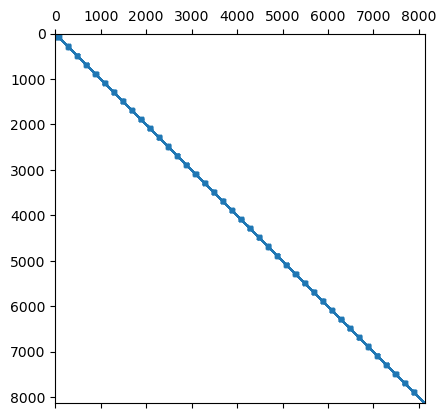

In [159]:
iBtB = solvers.fastBlockInverse(MP.Basis.T@MP.Basis)
spy(iBtB,markersize=0.2);

In [141]:
iBtB.nnz/np.prod(iBtB.shape)

0.20703921682885612

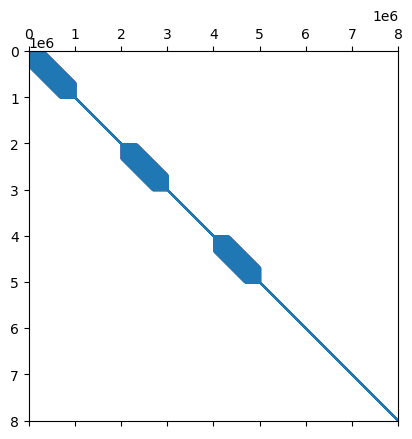

In [128]:
spy(iBtB,markersize=0.0018);

In [39]:
kv0 = bspline.make_knots(3,0.0,1.0,4)
kv1 = kv0.p_refine(1)

In [40]:
bspline.prolongation(kv0,kv1).A

array([[1.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00],
       [0.25, 0.75, 0.00, 0.00, 0.00, 0.00, 0.00],
       [0.00, 0.75, 0.25, 0.00, 0.00, 0.00, 0.00],
       [0.00, 0.13, 0.79, 0.08, 0.00, 0.00, 0.00],
       [0.00, 0.00, 0.50, 0.50, 0.00, 0.00, 0.00],
       [0.00, 0.00, 0.08, 0.83, 0.08, 0.00, 0.00],
       [0.00, 0.00, 0.00, 0.50, 0.50, 0.00, 0.00],
       [0.00, 0.00, 0.00, 0.08, 0.79, 0.13, 0.00],
       [0.00, 0.00, 0.00, 0.00, 0.25, 0.75, 0.00],
       [0.00, 0.00, 0.00, 0.00, 0.00, 0.75, 0.25],
       [0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 1.00]])

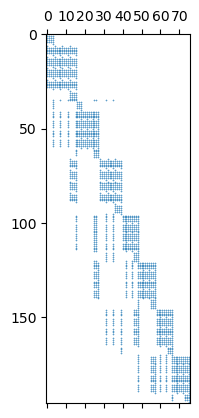

In [12]:
spy(P,markersize=0.2)

In [4]:
deg=3
kvs1 = bspline.make_knots(2,0.0,1.0,deg)
kvs2 =  bspline.make_knots(3,0.0,1.0,deg+1)
P = bspline.prolongation(kvs1,kvs2)

In [5]:
P.A

array([[1.00, 0.00, 0.00, 0.00, 0.00],
       [0.50, 0.50, 0.00, -0.00, 0.00],
       [-0.12, 0.92, 0.19, 0.01, -0.01],
       [0.03, -0.05, 1.03, -0.05, 0.03],
       [-0.01, 0.01, 0.19, 0.92, -0.12],
       [0.00, -0.00, 0.00, 0.50, 0.50],
       [0.00, 0.00, 0.00, 0.00, 1.00]])

In [2]:
def drawSkeleton(MP):
    for (p,b,_),(_,_,_),_ in MP.intfs:
        ax,sd=assemble.int_to_bdspec(b)
        geo=MP.mesh.geos()[p]
        kvs=MP.mesh.kvs()[p]
        grid=np.linspace(geo.support[(ax+1)%2][0], geo.support[(ax+1)%2][1],kvs[(ax+1)%2].numdofs)
        if (p,b) == (4,1) or (p,b)==(5,3): grid=grid[1:-1]
        if ax==0:
            Z = geo.eval(grid,np.array([geo.support[0][sd]]))
        else:
            Z = geo.eval(np.array([geo.support[1][sd]]),grid)
        plt.scatter(Z[:,:,0].ravel(),Z[:,:,1].ravel(),color='red',s=15,zorder=3)
    
def drawInterior(MP,r=1):
    for p in range(MP.numpatches):
        kvs, geo = MP.mesh.kvs()[p], MP.mesh.geos()[p]
        gridx=np.linspace(geo.support[0][0],geo.support[0][1] ,kvs[0].numdofs)
        gridy=np.linspace(geo.support[1][0],geo.support[1][1],kvs[1].numdofs)
        Z = geo.eval(gridx,gridy)
        if r != 0:
            plt.scatter(Z[r:-r,r:-r,0].ravel(),Z[r:-r,r:-r,1].ravel(),color='black',s=15)
        else:
            for idx in MP.mesh.outer_boundaries:
                if (p,2) not in MP.mesh.outer_boundaries[idx]: Z = Z[1:,:,:]
                if (p,3) not in MP.mesh.outer_boundaries[idx]: Z = Z[:-1,:,:]
                if (p,0) not in MP.mesh.outer_boundaries[idx]: Z = Z[:,1:,:]
                if (p,1) not in MP.mesh.outer_boundaries[idx]: Z = Z[:,:-1,:]
            plt.scatter(Z[:,:,0].ravel(),Z[:,:,1].ravel(),color='black',s=15,zorder=2)

In [6]:
2*(bspline.make_knots(2,0,1,2),)

(KnotVector(array([0. , 0. , 0. , 0.5, 1. , 1. , 1. ]), 2),
 KnotVector(array([0. , 0. , 0. , 0.5, 1. , 1. , 1. ]), 2))

In [9]:
patches=[(2*(bspline.make_knots(2,0,1,2),),geometry.unit_square())]
M = topology.PatchMesh(patches)
M.split_patches();
#M.refine({0:None});
M.split_patches({0:None});
M.refine({0:None});
MP=assemble.Multipatch(M, automatch=True)

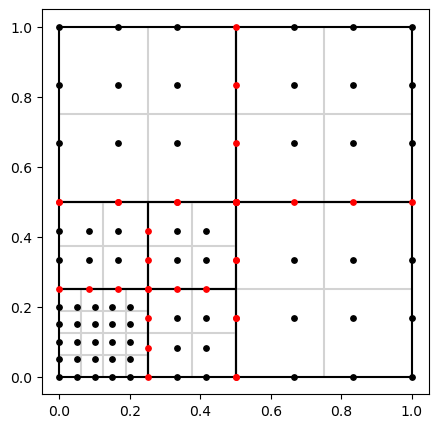

In [10]:
MP.mesh.draw(patch_idx=False)
drawInterior(MP,r=0)
drawSkeleton(MP)

In [6]:
kv1 ,kv2 = bspline.KnotVector(np.array([0.0,0.0,0.25,0.5,0.5]),1), bspline.KnotVector(np.array([0.0,0.0,0.5,0.7,0.8,0.9,1.0,1.0]),1)
bspline.prolongation(kv2,kv1).A

array([[1. , 0. , 0. , 0. , 0. , 0. ],
       [0.5, 0.5, 0. , 0. , 0. , 0. ],
       [0. , 1. , 0. , 0. , 0. , 0. ]])

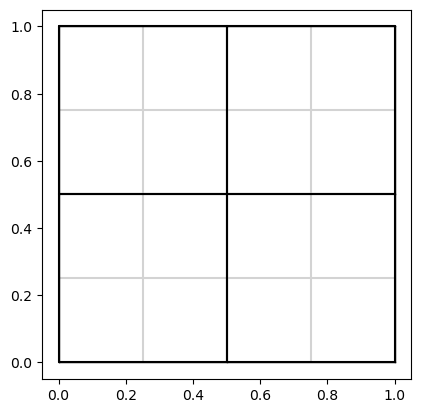

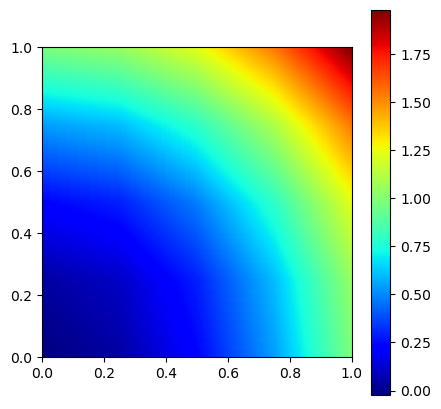

0


TypeError: 'dict_keys' object is not subscriptable

In [2]:
deg=2
kvs = [2 * (bspline.make_knots(1, 0.0, 1.0, deg),)]
geos = [geometry.unit_square()]
patches = [(k, g) for k, g in zip(kvs,geos)]
M = topology.PatchMesh(patches)
M.split_patches();
MP = assemble.Multipatch(M, automatch=True)
u1 = MP.L2projection(lambda x,y: x**2+y**2)
MP.mesh.draw(plt.figure())
axis('scaled');
MP.plot(u1)
P=MP.patch_refine({0:None,1:-1,2:-1,3:None},p_ref=deg+1, return_P=True)
MP.mesh.draw(plt.figure())
axis('scaled');
MP.plot(P@u1)

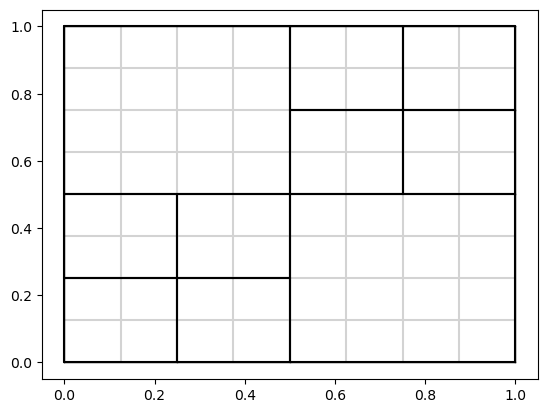

In [4]:
M.draw(plt.figure())

In [5]:
M.patches

[(((KnotVector(array([0.   , 0.   , 0.125, 0.25 , 0.25 ]), 1),
    KnotVector(array([0.   , 0.   , 0.125, 0.25 , 0.25 ]), 1)),
   <pyiga.bspline.BSplineFunc at 0x7f07983573a0>),
  ([0, 9], [11, 12], [0, 11], [9, 12])),
 (((KnotVector(array([0.   , 0.   , 0.125, 0.25 , 0.375, 0.5  , 0.5  ]), 1),
    KnotVector(array([0.5  , 0.5  , 0.625, 0.75 , 0.875, 1.   , 1.   ]), 1)),
   <pyiga.bspline.BSplineFunc at 0x7f079bfcaf40>),
  ([4, 1], [7, 14, 8], [4, 13, 7], [1, 8])),
 (((KnotVector(array([0.5  , 0.5  , 0.625, 0.75 , 0.875, 1.   , 1.   ]), 1),
    KnotVector(array([0.   , 0.   , 0.125, 0.25 , 0.375, 0.5  , 0.5  ]), 1)),
   <pyiga.bspline.BSplineFunc at 0x7f079bfcad00>),
  ([6, 10, 7], [2, 5], [6, 2], [7, 16, 5])),
 (((KnotVector(array([0.5  , 0.5  , 0.625, 0.75 , 0.75 ]), 1),
    KnotVector(array([0.5  , 0.5  , 0.625, 0.75 , 0.75 ]), 1)),
   <pyiga.bspline.BSplineFunc at 0x7f0798419dc0>),
  ([7, 14], [16, 17], [7, 16], [14, 17])),
 (((KnotVector(array([0.   , 0.   , 0.125, 0.25 , 0.25 ]),